Итоговый проект. 
Тема работы Lung_Canser.
Являюсь "чайником" от мира iT и "закостенелым" гуманитарием с 15 летним стажем работы в операционной. )))
Выражаю искренние слова благодарности!  
Учится с вашими наставлениями инетересно, хотя и совсем для человека далекого от точных наук непросто.
Но мы не ищем легких путей. )))

In [1702]:
# Импортируем набор библиотек для корректной работы нашего проекта.
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Метрики качества
from sklearn.metrics import r2_score as r2

In [1703]:
# "Игнорим" ошибки
import warnings
warnings.filterwarnings('ignore')

In [1704]:
# Умешьшаем объем занимаемой памяти. 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1705]:
# Устанавливаем текстовые параметры датасета. 
matplotlib.rcParams.update({'font.size': 16})

In [1706]:
# Подгружаем наш базовый файл, создаем Датасет для предварительной разведки данных.  
TRAIN_DATASET_PATH = 'C://Users//Mitro//OneDrive//Рабочий стол//survey lung cancer.csv'

In [1707]:
# читаем дадасет. 
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
304,F,56,1,1,1,2,2,2,1,1,2,2,2,2,1,YES
305,M,70,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
306,M,58,2,1,1,1,1,1,2,2,2,2,1,1,2,YES
307,M,67,2,1,2,1,1,2,2,1,2,2,2,1,2,YES
308,M,62,1,1,1,2,1,2,2,2,2,1,1,2,1,YES


Описание датасета. 
Данный датасет взят с Kaggle
https://www.kaggle.com/datasets/nancyalaswad90/lung-cancer

GENDER - пол  M(male), F(female)
AGE - возраст (числовая переменная)
LUNG_CANCER (Таргетная переменная) - рак легких. YES - есть, NO - нет

Для всех нижеперечисленных признаков верно условие: 
Да (признак положительный) = 2 , Нет (Признак отрицательный) = 1

SMOKING - курение  
YELLOW_FINGERS - жёлтые пальцы (пожелтение ногтевых пластин как следствие длительного курения табака)  
ANXIETY - тревожность (тревожные рассторойства)  
PEER_PRESSURE - психологическое давление со стороны окружающей среды (людей)  
CHRONIC DISEASE - хронические заболевания. 
FATIGUE - усталость 
ALLERGY - аллергия
WHEEZING - хрипы (признак обструктивной болезни легких при курении (ХОБЛ)
ALCOHOL CONSUMING - алкогольная зависимость. 
COUGHING - кашель. 
SHORTNESS OF BREATH - одышка. Снижение толерантности к физической нагрузке. 
SWALLOWING DIFFICULTY - нарушения глотания. 
CHEST PAIN - боли в грудной клетке. 

Целью нашей работы с датасетом будет обучение модели для предсказания развития рака легких. 
Имеющиеся различные признаки напрямую не являются 100% предиктором рака легкого, но при правильной группировке
могут с высокой точностью предсказать развитие опасного заболевания. 
                  
                  

Проведем EDA

In [1708]:
# используем метод "info" для получения ифнормации о дататсете. 
# номинативные признаки будем приводить к числовым категориальным. 
# таргетный признак - LUNG_CANCER
# пропусков данных нет. 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [1709]:
# проверим датасет на наличие пропусков в признаках.
train_df.isnull().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

In [1710]:
print('Строк в трейне:', train_df.shape[0])

Строк в трейне: 309


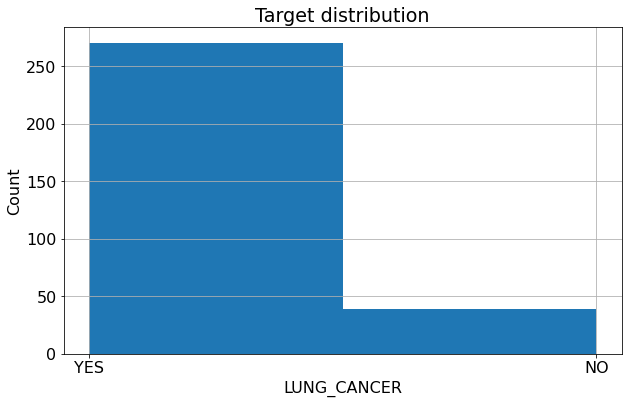

In [1711]:
# Построим гистограмму таргетного признака. 
plt.figure(figsize = (10, 6))

train_df['LUNG_CANCER'].hist(bins=2)
plt.ylabel('Count')
plt.xlabel('LUNG_CANCER')

plt.title('Target distribution')
plt.show()

In [1712]:
# Используем функцию Функция describe которая оценивает столбцы с числовым типом данных (int или float) и 
# возвращает статистические данные, которые дают представление о распределении значений.(среднее значение, среднее квардатичное
# отклонение, мнимальные и максимальные значения, квантили)
train_df.describe()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,62.673139,1.563107,1.569579,1.498382,1.501618,1.504854,1.673139,1.556634,1.556634,1.556634,1.579288,1.640777,1.469256,1.556634
std,8.210301,0.496806,0.495938,0.500808,0.500808,0.500787,0.469827,0.497588,0.497588,0.497588,0.494474,0.480551,0.499863,0.497588
min,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,62.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000
75%,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,87.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


array([[<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'SMOKING'}>,
        <AxesSubplot:title={'center':'YELLOW_FINGERS'}>,
        <AxesSubplot:title={'center':'ANXIETY'}>],
       [<AxesSubplot:title={'center':'PEER_PRESSURE'}>,
        <AxesSubplot:title={'center':'CHRONIC DISEASE'}>,
        <AxesSubplot:title={'center':'FATIGUE '}>,
        <AxesSubplot:title={'center':'ALLERGY '}>],
       [<AxesSubplot:title={'center':'WHEEZING'}>,
        <AxesSubplot:title={'center':'ALCOHOL CONSUMING'}>,
        <AxesSubplot:title={'center':'COUGHING'}>,
        <AxesSubplot:title={'center':'SHORTNESS OF BREATH'}>],
       [<AxesSubplot:title={'center':'SWALLOWING DIFFICULTY'}>,
        <AxesSubplot:title={'center':'CHEST PAIN'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

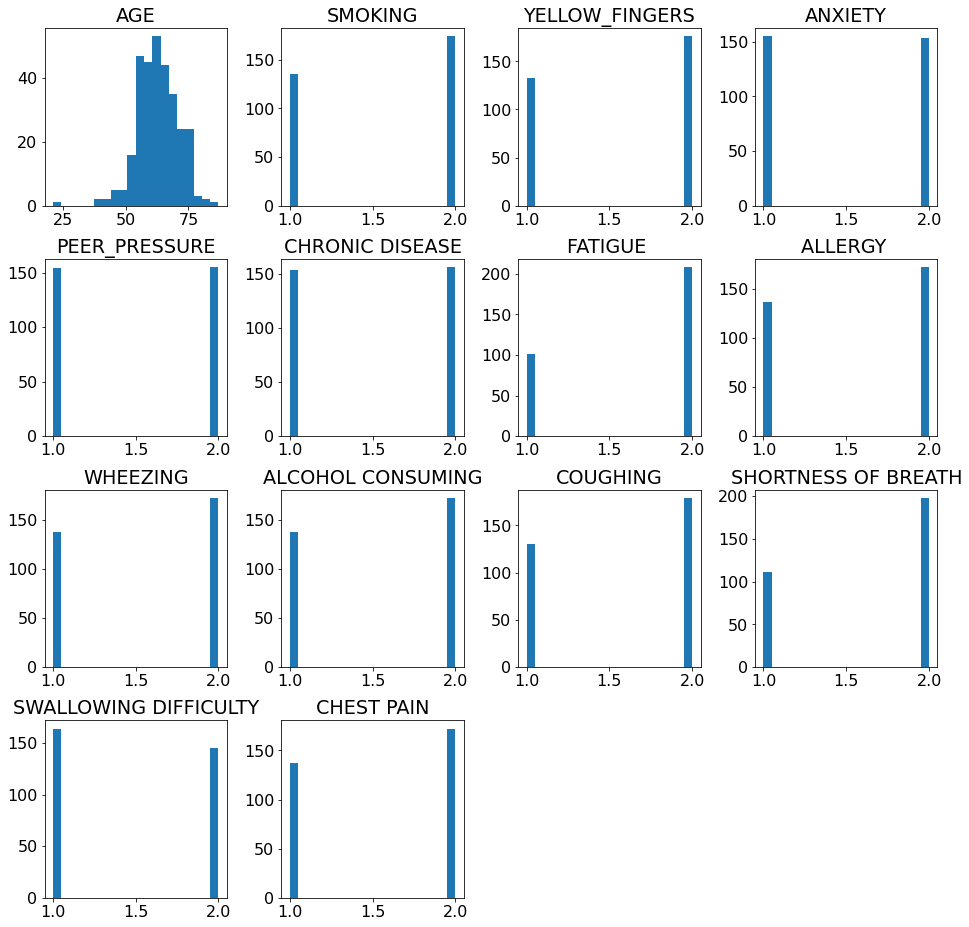

In [1713]:
# Постротим гистограммы категориальных признаков 
train_df.hist(figsize=(16,16), bins=20, grid=False)

In [1714]:
# проверим датасет на номинативные переменные. 
train_df.select_dtypes(include='object').columns.tolist()

['GENDER', 'LUNG_CANCER']

In [1715]:
train_df['GENDER'].value_counts()

M    162
F    147
Name: GENDER, dtype: int64

In [1716]:
train_df['LUNG_CANCER'].value_counts()

YES    270
NO      39
Name: LUNG_CANCER, dtype: int64

In [1717]:
train_df['LUNG_CANCER'].describe()

count     309
unique      2
top       YES
freq      270
Name: LUNG_CANCER, dtype: object

Обработка выбросов

<AxesSubplot:xlabel='AGE'>

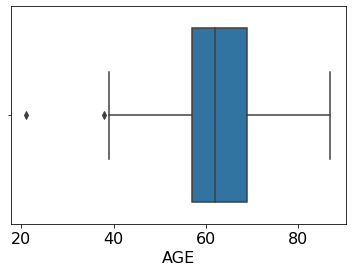

In [1718]:
# Построим "ящик с усами" для признака AGE - ищем выбросы. 
sns.boxplot(train_df.AGE)

In [1719]:
# найдем значения близкие к min и max 
train_df['AGE'].quantile(.975), train_df['AGE'].quantile(.025)

(77.0, 47.0)

In [1720]:
condition = (train_df['AGE'].isna()) \
             | (train_df['AGE'] < train_df['AGE'].quantile(.025))
        
train_df.loc[condition, 'AGE'] = train_df['AGE'].median()
# используя маску заменим все значения ниже quantile(.025) медианой. 

<AxesSubplot:xlabel='AGE'>

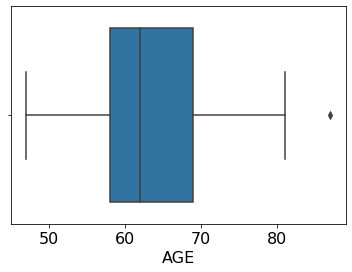

In [1721]:
# проверим на выбросы повторно.
sns.boxplot(train_df.AGE)

In [1722]:
condition = (train_df['AGE'].isna()) \
             | (train_df['AGE'] > train_df['AGE'].quantile(.975))
        
train_df.loc[condition, 'AGE'] = train_df['AGE'].median()
# используя маску заменим все значения выше quantile(.975) медианой. 

<AxesSubplot:xlabel='AGE'>

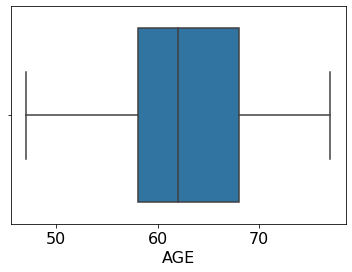

In [1723]:
# проверим еще разок - выбросов нет.
sns.boxplot(train_df.AGE)

Построение новых признаков. 

In [1724]:
# Неколичественные строковые признаки всегда нужно переводить в числовое представление 
train_df['GENDER'] = train_df['GENDER'].map({'F': 0, 'M': 1})
train_df['LUNG_CANCER'] = train_df['LUNG_CANCER'].map({'NO': 0, 'YES': 1})

In [1725]:
train_df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


Создаем новые признаки.

In [1726]:
# Объединим признак тревожнось и подверженность психологическому давлению с стороны окружающих в признак ментальный статус
train_df['MENTAL_STATUS'] = train_df['PEER_PRESSURE'] + train_df['ANXIETY']

In [1727]:
# Объединим клинические признаки бронихиальной астмы ('WHEEZING' 'COUGHING' 'SHORTNESS OF BREATH') 
train_df['BRONCHIAL_ASTMA'] = train_df['WHEEZING'] + train_df['COUGHING'] + train_df['SHORTNESS OF BREATH']         

In [1728]:
# Пожелтение пальцев и ногтевых пластин признак тяжелого поражения при длительном курении, объединим эти два признака 
# в новый и назовем его HARD_SMOKING
train_df['HARD_SMOKING'] = train_df['YELLOW_FINGERS'] + train_df['SMOKING']

In [1729]:
# Хронические заболевания в слчетании с алкогольной зависимостью осложняются циррозом печени.
# Объединим признаки 'CHRONIC DISEASE' и 'ALCOHOL CONSUMING'
train_df['LIVER_CIRROSIS'] = train_df['CHRONIC DISEASE'] + train_df['ALCOHOL CONSUMING']

In [1730]:
train_df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,MENTAL_STATUS,BRONCHIAL_ASTMA,HARD_SMOKING,LIVER_CIRROSIS
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1,3,6,3,3
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1,2,4,3,3
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0,3,6,2,2
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0,3,3,4,3
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0,2,6,3,2


In [1731]:
# пропишем признаки. 
feature_names = ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING', 'ALCOHOL CONSUMING',
                  'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']
new_feature_names = ['MENTAL_STATUS', 'BRONCHIAL_ASTMA', 'HARD_SMOKING', 'LIVER_CIRROSIS']
target_name = 'LUNG_CANCER'

In [1732]:
train_df.describe()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,MENTAL_STATUS,BRONCHIAL_ASTMA,HARD_SMOKING,LIVER_CIRROSIS
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,0.524272,62.763754,1.563107,1.569579,1.498382,1.501618,1.504854,1.673139,1.556634,1.556634,1.556634,1.579288,1.640777,1.469256,1.556634,0.873786,3.000000,4.776699,3.132686,3.061489
std,0.500221,6.951538,0.496806,0.495938,0.500808,0.500808,0.500787,0.469827,0.497588,0.497588,0.497588,0.494474,0.480551,0.499863,0.497588,0.332629,0.781274,1.028162,0.696839,0.706720
min,0.000000,47.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,3.000000,2.000000,2.000000
25%,0.000000,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,3.000000,3.000000
50%,1.000000,62.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,3.000000,5.000000,3.000000,3.000000
75%,1.000000,68.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,4.000000,6.000000,4.000000,4.000000
max,1.000000,77.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,4.000000,6.000000,4.000000,4.000000


In [1733]:
train_df = train_df[feature_names + new_feature_names + [target_name]]
train_df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,MENTAL_STATUS,BRONCHIAL_ASTMA,HARD_SMOKING,LIVER_CIRROSIS,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,3,6,3,3,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,2,4,3,3,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,3,6,2,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,3,3,4,3,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,2,6,3,2,0


In [1734]:
# используем метод "info" для получения ифнормации о дататсете после обработки и генерации новых фич. 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   GENDER                 309 non-null    int64
 1   AGE                    309 non-null    int64
 2   SMOKING                309 non-null    int64
 3   YELLOW_FINGERS         309 non-null    int64
 4   ANXIETY                309 non-null    int64
 5   PEER_PRESSURE          309 non-null    int64
 6   CHRONIC DISEASE        309 non-null    int64
 7   FATIGUE                309 non-null    int64
 8   ALLERGY                309 non-null    int64
 9   WHEEZING               309 non-null    int64
 10  ALCOHOL CONSUMING      309 non-null    int64
 11  COUGHING               309 non-null    int64
 12  SHORTNESS OF BREATH    309 non-null    int64
 13  SWALLOWING DIFFICULTY  309 non-null    int64
 14  CHEST PAIN             309 non-null    int64
 15  MENTAL_STATUS          309 non-null    i

Выполним стандартизацию признаков

In [1735]:
feature_names_for_stand = train_df[feature_names + new_feature_names].select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_names_for_stand

['GENDER',
 'AGE',
 'SMOKING',
 'YELLOW_FINGERS',
 'ANXIETY',
 'PEER_PRESSURE',
 'CHRONIC DISEASE',
 'FATIGUE ',
 'ALLERGY ',
 'WHEEZING',
 'ALCOHOL CONSUMING',
 'COUGHING',
 'SHORTNESS OF BREATH',
 'SWALLOWING DIFFICULTY',
 'CHEST PAIN',
 'MENTAL_STATUS',
 'BRONCHIAL_ASTMA',
 'HARD_SMOKING',
 'LIVER_CIRROSIS']

In [1736]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(train_df[feature_names_for_stand])

In [1737]:
stand_features

array([[ 0.95257934,  0.89855824, -1.13529242, ...,  1.19172361,
        -0.19072037, -0.0871468 ],
       [ 0.95257934,  1.61899025,  0.88083033, ..., -0.75664991,
        -0.19072037, -0.0871468 ],
       [-1.04978132, -0.54230578, -1.13529242, ...,  1.19172361,
        -1.6281007 , -1.50442888],
       ...,
       [ 0.95257934, -0.68639218,  0.88083033, ...,  0.21753685,
        -0.19072037, -0.0871468 ],
       [ 0.95257934,  0.61038544,  0.88083033, ...,  0.21753685,
        -0.19072037, -0.0871468 ],
       [ 0.95257934, -0.11004657, -1.13529242, ..., -0.75664991,
        -1.6281007 , -0.0871468 ]])

In [1738]:
train_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [1739]:
# проверим датасет после стандартизации. 
train_df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,MENTAL_STATUS,BRONCHIAL_ASTMA,HARD_SMOKING,LIVER_CIRROSIS,LUNG_CANCER
0,0.952579,0.898558,-1.135292,0.869300,1.003241,-1.003241,-1.009756,0.696833,-1.120480,0.892475,0.892475,0.852207,0.748736,1.063501,0.892475,0.000000,1.191724,-0.190720,-0.087147,1
1,0.952579,1.618990,0.880830,-1.150351,-0.996769,-1.003241,0.990338,0.696833,0.892475,-1.120480,-1.120480,-1.173424,0.748736,1.063501,0.892475,-1.282036,-0.756650,-0.190720,-0.087147,1
2,-1.049781,-0.542306,-1.135292,-1.150351,-0.996769,0.996769,-1.009756,0.696833,-1.120480,0.892475,-1.120480,0.852207,0.748736,-0.940291,0.892475,0.000000,1.191724,-1.628101,-1.504429,0
3,0.952579,0.034040,0.880830,0.869300,1.003241,-1.003241,-1.009756,-1.435063,-1.120480,-1.120480,0.892475,-1.173424,-1.335584,1.063501,0.892475,0.000000,-1.730837,1.246660,-0.087147,0
4,-1.049781,0.034040,-1.135292,0.869300,-0.996769,-1.003241,-1.009756,-1.435063,-1.120480,0.892475,-1.120480,0.852207,0.748736,-0.940291,-1.120480,-1.282036,1.191724,-0.190720,-1.504429,0


Построение модели. 

In [1740]:
# подготовимся к построению модели. 
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [1741]:
# с помощью метода train_test_split разбиваем датасет. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [1742]:
# # для построения нашей модели будем исмользовать алгоритм RandomForestRegressor ("случайного леса"). 
model1 = RandomForestRegressor(n_estimators=10,max_depth=5,n_jobs=-1,random_state=21)
model1.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, n_jobs=-1, random_state=21)

In [1743]:
y_pred_train = model1.predict(X_train)
y_test_preds = model1.predict(X_test)

In [1744]:
# проверяем с помощью метрики R2 
print("train score ",r2(y_train,y_pred_train))
print("test score ",r2(y_test, y_test_preds))

train score  0.7697334086160597
test score  0.6268641953230998


In [1745]:
# посмотрим какие фичи имеют наибольшее значение. 
feature_importances = pd.DataFrame(zip(X_train.columns, model1.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,AGE,0.214650
15,MENTAL_STATUS,0.156497
3,YELLOW_FINGERS,0.109694
16,BRONCHIAL_ASTMA,0.107526
18,LIVER_CIRROSIS,0.087652
17,HARD_SMOKING,0.040622
2,SMOKING,0.036023
7,FATIGUE,0.030854
8,ALLERGY,0.029552
13,SWALLOWING DIFFICULTY,0.028655
